# Reinforcement Learning in Finite MDPs

In [1]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [7]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from cliffwalk import CliffWalk

In [9]:
from test_env import ToyEnv1

Setting up the environment

In [130]:
env = CliffWalk(proba_succ=0.98)

## Smaller env!
#env = ToyEnv1(gamma=0.99)

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [2 0 0 0 0 2 3 2 0 0 2 0 2 0 3 1 3 3 2 0 0 2 1 1 1 1 1 3 0 3 2 2 3 1 2 1 3
 3 2 2 3 2 3 0 1 2 0 0]
(s, a, s', r):
36 3 24 0.6
24 1 36 0.6
36 3 24 0.6
24 1 36 0.6



## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$

$$
\newcommand\calA{\mathcal A}
$$

**Recall** The Bellman operator operates on an input value function $Q_0$ as
$$
    LQ_0(s,a) = \sum_{s'} \left(r(s, a, s') + \gamma \max_{a'\in\calA}Q_0(s',a')\right) p(s'|s, a)
$$


In [131]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, R, P, gamma):
    r"""
    Args:
        Q0: input state-action value func
        R: pre-computed S x A x S reward function values
        P: proba transition matrix
    """
    
    Q_max_act = np.max(Q0, axis=1)[None,None,...]
    Q1 = np.sum((R + gamma * Q_max_act) * P, axis=2)
    greedy_policy = np.argmax(Q1, axis=1)
    
    return Q1, greedy_policy

# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5, print_every=100):
    # TODO (feel free to change the return argument)

    # Precompute the S x A x S reward tensor
    import itertools
    R_ = np.empty((env.Ns, env.Na, env.Ns))
    for s, a, sprime in itertools.product(env.states, env.actions, env.states):
        R_[s, a, sprime] = env.reward_func(s, a, sprime)

    Q = Q0.copy()
    Q_history = []
    Q_history.append(Q)
    norm = np.inf
    its = 0
    norm_vals = [norm]
    while norm > epsilon:
        if its % print_every == 0:
            print("Iteration #%d -- norm=%.3e" % (its, norm))
        Q_new, greedy_policy = bellman_operator(Q, R_, env.P, env.gamma)
        deltaV = np.absolute(Q_new.max(axis=1) - Q.max(axis=1))
        norm = np.max(deltaV)
        norm_vals.append(norm)
        # Set Q as Q_new
        Q = Q_new
        # add to history
        Q_history.append(Q)
        
        its += 1
    
    return Q, greedy_policy, Q_history, norm_vals

In [132]:
## SANITY TEST FOR BELLMAN_OPERATOR

import itertools

R_ = np.empty((env.Ns, env.Na, env.Ns))
for s, a, sprime in itertools.product(env.states, env.actions, env.states):
    R_[s, a, sprime] = env.reward_func(s, a, sprime)

In [133]:
## Sanity test
Q0_ = np.random.rand(env.Ns, env.Na)
print('Q0 shape', Q0_.shape)
Q1_, pol_ = bellman_operator(Q0_, R_, env.P, env.gamma)

Q0 shape (48, 4)


In [134]:
# --------------
# Point 3
# --------------

## Load data

with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]

Qstar = np.array(Qstar)

Q, greedy_policy, Q_history, norm_values = value_iteration(Q0_, env, print_every=50)

Iteration #0 -- norm=inf
Iteration #50 -- norm=4.141e-01
Iteration #100 -- norm=2.366e-01
Iteration #150 -- norm=1.412e-01
Iteration #200 -- norm=8.483e-02
Iteration #250 -- norm=5.108e-02
Iteration #300 -- norm=3.080e-02
Iteration #350 -- norm=1.858e-02
Iteration #400 -- norm=1.122e-02
Iteration #450 -- norm=6.776e-03
Iteration #500 -- norm=4.095e-03
Iteration #550 -- norm=2.475e-03
Iteration #600 -- norm=1.496e-03
Iteration #650 -- norm=9.048e-04
Iteration #700 -- norm=5.471e-04
Iteration #750 -- norm=3.309e-04
Iteration #800 -- norm=2.001e-04
Iteration #850 -- norm=1.211e-04
Iteration #900 -- norm=7.323e-05
Iteration #950 -- norm=4.430e-05
Iteration #1000 -- norm=2.680e-05
Iteration #1050 -- norm=1.621e-05


In [141]:
dist_to_opt = np.array([np.max(Qstar.max(axis=1) - Q.max(axis=1)) for Q in Q_history])

Text(0.5, 1.0, 'Value iteration: Convergence of state-action Q')

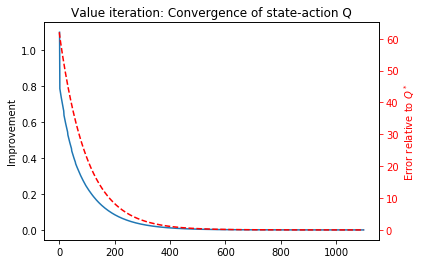

In [154]:
plt.plot(norm_values, label="Improvement at each step")
plt.ylabel("Improvement")
plt.twinx()

plt.plot(dist_to_opt, label="Distance to $Q^*$", c='r', ls='--')
plt.tick_params(colors='r',grid_color='r')


plt.xlabel('Iteration')
plt.ylabel('Error relative to $Q^*$', c='r')
plt.title("Value iteration: Convergence of state-action Q")

In [136]:
greedy_policy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0])

In [137]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (down)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [329]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, Ns, Na, env, epsilon=0.3):
        self.Ns = Ns
        self.Na = Na
        self.env = env
        self.Q = np.random.rand(Ns, Na)  # S x A initial "guess" for Q function
        self.epsilon = epsilon
    
    def sample_action(self, state):
        """
        Take the best short-term (greedy) action with proba 1 - epsilon
        or take a random action.
        
        Args
            state:  state for which we want to take an action
        """
        u = np.random.rand()
        if u < 1 - self.epsilon:
            idx = np.argmax(self.Q[state])
            return self.env.action_sets[state][idx]
        else:
            # Choose an action uniformly
            return np.random.choice(self.env.action_sets[state])
    
    def update(self, state, action, next_state, reward, alpha):
        """
        Given the state, action, next state and reward trajectory slice,
        update the Q function.
        """
        delta = reward + self.env.gamma * np.max(self.Q[next_state]) - self.Q[state, action]
        self.Q[state, action] = self.Q[state, action] + alpha * delta

In [386]:
# --------------
# Point 1
# --------------
# Number of Q learning steps
# max_steps = int(1e5)  
max_steps = 60000

Q0 = np.zeros((env.Ns, env.Na))
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt, *_ = value_iteration(Q0, env, epsilon=1e-8)

Iteration #0 -- norm=inf
Iteration #100 -- norm=2.459e-01
Iteration #200 -- norm=8.710e-02
Iteration #300 -- norm=3.148e-02
Iteration #400 -- norm=1.144e-02
Iteration #500 -- norm=4.169e-03
Iteration #600 -- norm=1.522e-03
Iteration #700 -- norm=5.563e-04
Iteration #800 -- norm=2.034e-04
Iteration #900 -- norm=7.441e-05
Iteration #1000 -- norm=2.722e-05
Iteration #1100 -- norm=9.963e-06
Iteration #1200 -- norm=3.646e-06
Iteration #1300 -- norm=1.334e-06
Iteration #1400 -- norm=4.884e-07
Iteration #1500 -- norm=1.788e-07
Iteration #1600 -- norm=6.543e-08
Iteration #1700 -- norm=2.395e-08


In [384]:
ql = QLearning(env.Ns, env.Na, env, epsilon=.5)

# main algorithmic loop
norm_values = []
t = 0
state = env.reset()
cum_rewards = [0.]

while t < max_steps:
    action = ql.sample_action(state)
    observation, reward, done, info = env.step(action)
    alpha = 2. / np.log(2 + np.log(1+t))
    ql.update(state, action, observation, reward, alpha)
    norm_values.append(np.abs(ql.Q - Q_opt).mean())

    t += 1
    state = observation
    cum_rewards.append(env.gamma * cum_rewards[-1] + reward)

norm_values = np.array(norm_values)

env.render()
print("Opt. policy:", pi_opt)
greedy_policy = np.argmax(ql.Q, axis=1)
print("Est. policy:", greedy_policy)

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : :_: : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
Opt. policy: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]
Est. policy: [1 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 2 3 3 3 3 3 3 3 3 0 0]


Final norm: 0.07228214204191115


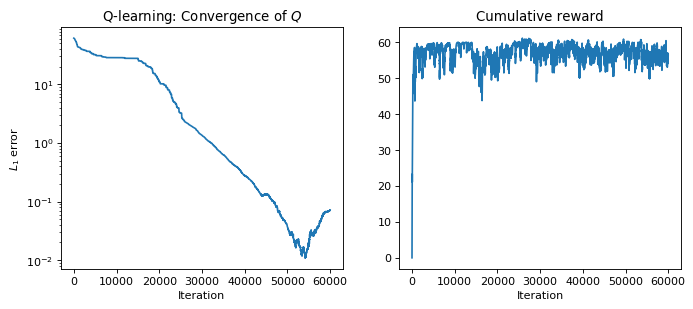

In [385]:
fig = plt.figure(dpi=80, figsize=(10, 4))
plt.subplot(121)
plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('$L_1$ error')
plt.title("Q-learning: Convergence of $Q$")

plt.yscale('log')

plt.subplot(122)
plt.plot(cum_rewards)
plt.xlabel('Iteration')
plt.title("Cumulative reward")

print("Final norm:", norm_values[-1])

# how confident are you in the performance of the algorithm? maybe a single run is not enough